In [36]:
#import train data and test data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.formula.api as sm
from sklearn.model_selection import train_test_split

movie_data = pd.read_csv('movie_metadata.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [37]:
movie_data['profit'] = movie_data['gross'] - movie_data['budget']
movie_data['profit_binary'] = np.where(movie_data['profit'] > 0, 1, 0)


In [38]:
movie_data.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'genres', 'actor_1_name',
       'movie_title', 'num_voted_users', 'cast_total_facebook_likes',
       'actor_3_name', 'facenumber_in_poster', 'plot_keywords',
       'movie_imdb_link', 'num_user_for_reviews', 'language', 'country',
       'content_rating', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'profit',
       'profit_binary'],
      dtype='object')

In [39]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(movie_data, test_size=0.2, random_state=42)

# Save the training and testing data as CSV files
train_data.to_csv('movie_train.csv', index=False)
test_data.to_csv('movie_test.csv', index=False)

movie_train = pd.read_csv('movie_train.csv')
movie_test =pd.read_csv('movie_test.csv')

In [40]:
logit_model = sm.logit(formula = 'profit_binary~duration+director_facebook_likes+actor_3_facebook_likes+actor_1_facebook_likes+cast_total_facebook_likes+facenumber_in_poster+title_year+actor_2_facebook_likes+aspect_ratio+movie_facebook_likes', data = movie_train).fit() #Developing logistic regression model
logit_model.summary()

Optimization terminated successfully.
         Current function value: 0.652394
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          profit_binary   No. Observations:                 3694
Model:                          Logit   Df Residuals:                     3683
Method:                           MLE   Df Model:                           10
Date:                Sun, 05 Mar 2023   Pseudo R-squ.:                 0.04868
Time:                        23:32:11   Log-Likelihood:                -2409.9
converged:                       True   LL-Null:                       -2533.3
Covariance Type:            nonrobust   LLR p-value:                 2.785e-47
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    23.6844      5.959      3.974      0.000      12.004      35.365
duration                     -0.0005      0.002     -0.306      0.760      -0.004       0.003
director_facebook_likes    3.142e-05   1.28e-05      2.451      0.014    6.29e-06    5.65e-05
actor_3_facebook_likes       -0.0004   6.51e-05     -5.549      0.000      -0.000      -0.000
actor_1_facebook_likes       -0.0003   4.57e-05     -7.381      0.000      -0.000      -0.000
cast_total_facebook_likes     0.0003   4.54e-05      7.468      0.000       0.000       0.000
facenumber_in_poster         -0.0040      0.017     -0.235      0.814      -0.038       0.029
title_year                   -0.0120      0.003     -4.004      0.000      -0.018      -0.006
actor_2_facebook_likes       -0.0003   4.76e-05     -6.984      0.000      -0.000      -0.000
aspect_ratio                 -0.1970      0.098     -2.004      0.045      -0.390      -0.004
movie_facebook_likes       2.335e-05   2.51e-06      9.313      0.000    1.84e-05    2.83e-05
=============================================================================================
"""

In [41]:
#Function to compute confusion matrix and prediction accuracy on training data
def confusion_matrix_train(model,cutoff=0.5):
    # Confusion matrix
    cm_df = pd.DataFrame(model.pred_table(threshold = cutoff))
    #Formatting the confusion matrix
    cm_df.columns = ['Predicted 0', 'Predicted 1'] 
    cm_df = cm_df.rename(index={0: 'Actual 0',1: 'Actual 1'})
    cm = np.array(cm_df)
    # Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 62.0%


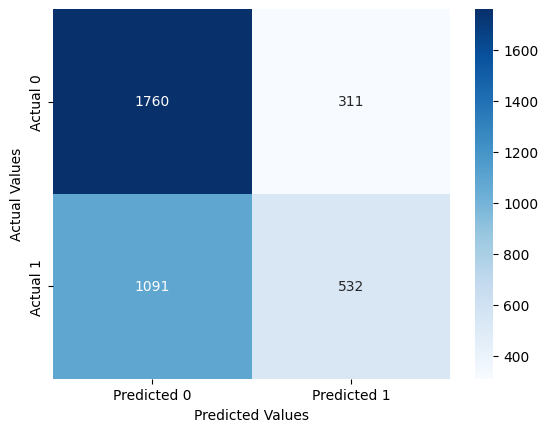

In [42]:
cm = confusion_matrix_train(logit_model)

In [43]:
#Function to compute confusion matrix and prediction accuracy on test data
def confusion_matrix_test(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))

Classification accuracy = 59.8%


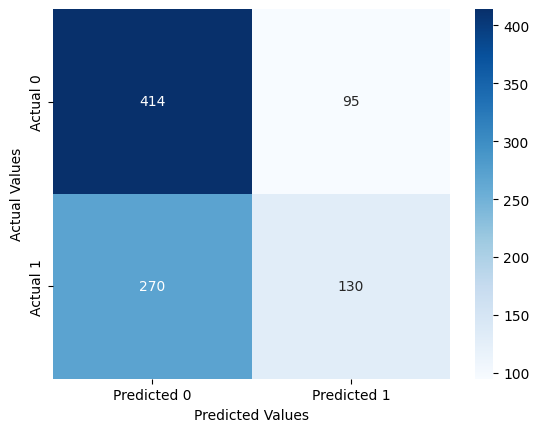

In [44]:
confusion_matrix_test(movie_test,movie_test.profit_binary,logit_model)

In [45]:
from sklearn.metrics import roc_curve, auc
y=movie_train.profit_binary
ypred = logit_model.predict(movie_train)
fpr, tpr, auc_thresholds = roc_curve(y, ypred)
print(auc(fpr, tpr))# AUC of ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")

fpr, tpr, auc_thresholds = roc_curve(y, ypred)
plot_roc_curve(fpr, tpr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
#Function to compute confusion matrix and prediction accuracy on test/train data
def confusion_matrix_data(data,actual_values,model,cutoff=0.5):
#Predict the values using the Logit model
    pred_values = model.predict(data)
# Specify the bins
    bins=np.array([0,cutoff,1])
#Confusion matrix
    cm = np.histogram2d(actual_values, pred_values, bins=bins)[0]
    cm_df = pd.DataFrame(cm)
    cm_df.columns = ['Predicted 0','Predicted 1']
    cm_df = cm_df.rename(index={0: 'Actual 0',1:'Actual 1'})
# Calculate the accuracy
    accuracy = (cm[0,0]+cm[1,1])/cm.sum()
    fnr = (cm[1,0])/(cm[1,0]+cm[1,1])
    precision = (cm[1,1])/(cm[0,1]+cm[1,1])
    fpr = (cm[0,1])/(cm[0,0]+cm[0,1])
    tpr = (cm[1,1])/(cm[1,0]+cm[1,1])
    fpr_roc, tpr_roc, auc_thresholds = roc_curve(actual_values, pred_values)
    auc_value = (auc(fpr_roc, tpr_roc))# AUC of ROC
    sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
    plt.ylabel("Actual Values")
    plt.xlabel("Predicted Values")
    print("Classification accuracy = {:.1%}".format(accuracy))
    print("Precision = {:.1%}".format(precision))
    print("TPR or Recall = {:.1%}".format(tpr))
    print("FNR = {:.1%}".format(fnr))
    print("FPR = {:.1%}".format(fpr))
    print("ROC-AUC = {:.1%}".format(auc_value))

In [ ]:
confusion_matrix_data(movie_test,movie_test.profit_binary,logit_model,0.5)

NameError: name 'roc_curve' is not defined